In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.models import resnet34
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import evaluate
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier

import copy
from pathlib import Path
import random
from statistics import mean

import numpy as np

## Ensuring reproducibility by setting the random seed

In [ ]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Setup

In [ ]:
DEVICE = "cuda"
n_workers = 2

In [ ]:
# Define transform for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load the dataset
train_dataset = ImageFolder('train', transform=transform)
test_dataset = ImageFolder('test', transform=transform)
val_dataset = ImageFolder('val', transform=transform)

In [ ]:
def get_labels(dataset):
    return [sample[1] for sample in dataset.samples]

# Add get_labels method to the datasets
train_dataset.get_labels = lambda: get_labels(train_dataset)
test_dataset.get_labels = lambda: get_labels(test_dataset)
val_dataset.get_labels = lambda: get_labels(val_dataset)

## Define the network

We initiate PrototypicalNetworks using ResNet34 as backbone. We set weights = True to use the pretrained weights, then its head is chopped off and replaced by a Flatten layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.



In [ ]:
convolutional_network = resnet34(weights=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

few_shot_classifier = PrototypicalNetworks(convolutional_network).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 160MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Accuracy before training (100-way 1-shot)

In [ ]:
n_test_tasks = 1000
n_way = 100
n_shot = 1
n_query = 1
test_sampler = TaskSampler(
    test_dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [14:48<00:00,  1.13it/s, accuracy=0.678]

Average accuracy : 67.84 %


Accuracy before training (100-way 3-shot)

In [ ]:
n_test_tasks = 1000
n_way = 100
n_shot = 3
n_query = 1
test_sampler = TaskSampler(
    test_dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|██████████| 1000/1000 [41:07<00:00,  2.47s/it, accuracy=0.859]

Average accuracy : 85.88 %


## Training

We define our data loaders for training and validation. We use TaskSampler, which are built-in objects from EasyFSL, to sample batches in the shape of few-shot classification tasks.



In [ ]:
n_tasks_per_epoch = 500
n_validation_tasks = 100
n_way = 100
n_shot = 1
n_query = 1

# Those are special batch samplers that sample few-shot classification tasks with a pre-defined shape
train_sampler = TaskSampler(
    train_dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_tasks_per_epoch
)
val_sampler = TaskSampler(
    val_dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

# Finally, the DataLoader. We customize the collate_fn so that batches are delivered
# in the shape: (support_images, support_labels, query_images, query_labels, class_ids)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

Here, we use Stochastic Gradient Descent on 8 epochs with a scheduler that divides the learning rate by 10 after 3, 5 epochs.

In [ ]:
LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 8
scheduler_milestones = [3, 5]
scheduler_gamma = 0.1
learning_rate = 1e-2

train_optimizer = SGD(
    few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)


Here we define the function that performs a training epoch.

We use tqdm to monitor the training in real time in our logs.

In [ ]:
def training_epoch(
    model: FewShotClassifier, data_loader: DataLoader, optimizer: Optimizer
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()
            model.process_support_set(
                support_images.to(DEVICE), support_labels.to(DEVICE)
            )
            classification_scores = model(query_images.to(DEVICE))

            loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

To perform validations we'll just use the built-in evaluate function from easyfsl.methods.utils.

And we start training.

In [ ]:
best_state = few_shot_classifier.state_dict()
best_validation_accuracy = 0.0

train_loss_history = []
val_acc_history = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(few_shot_classifier, train_loader, train_optimizer)
    validation_accuracy = evaluate(
        few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
    )

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(few_shot_classifier.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        print("Ding ding ding! We found a new best model!")

    train_loss_history.append(average_loss)
    val_acc_history.append(validation_accuracy)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

Epoch 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation:  28%|██▊       | 28/100 [00:27<00:54,  1.33it/s, accuracy=0.895]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  58%|█████▊    | 58/100 [00:54<00:34,  1.21it/s, accuracy=0.893]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s, accuracy=0.892]

Ding ding ding! We found a new best model!
Epoch 1



Validation:  23%|██▎       | 23/100 [00:20<00:58,  1.32it/s, accuracy=0.898]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  43%|████▎     | 43/100 [00:37<00:46,  1.21it/s, accuracy=0.893]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, accuracy=0.891]

Epoch 2



Validation:  35%|███▌      | 35/100 [00:32<00:53,  1.21it/s, accuracy=0.9]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  53%|█████▎    | 53/100 [00:47<00:37,  1.25it/s, accuracy=0.897]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s, accuracy=0.896]

Ding ding ding! We found a new best model!
Epoch 3



Validation:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   7%|▋         | 7/100 [00:06<01:25,  1.09it/s, accuracy=0.891]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s, accuracy=0.899]

Ding ding ding! We found a new best model!
Epoch 4



Validation:   1%|          | 1/100 [00:02<03:42,  2.25s/it, accuracy=0.89]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   2%|▏         | 2/100 [00:02<02:01,  1.24s/it, accuracy=0.895]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s, accuracy=0.907]


Ding ding ding! We found a new best model!
Epoch 5


Validation:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s, accuracy=0.9]

Epoch 6



Validation:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   8%|▊         | 8/100 [00:07<01:12,  1.27it/s, accuracy=0.885]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s, accuracy=0.893]

Epoch 7



Validation:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:   8%|▊         | 8/100 [00:07<01:09,  1.33it/s, accuracy=0.904]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s, accuracy=0.904]


## Evaluation

Let's test our train model.

In [ ]:
few_shot_classifier.load_state_dict(best_state)

<All keys matched successfully>

Accuracy after training (100-way 1-shot)

In [ ]:
n_test_tasks = 1000

test_sampler = TaskSampler(
    test_dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|██████████| 1000/1000 [15:32<00:00,  1.07it/s, accuracy=0.918]

Average accuracy : 91.83 %


Accuracy after training (100-way 3-shot)

In [ ]:
n_test_tasks = 1000
n_way = 100
n_shot = 3
n_query = 1

test_sampler = TaskSampler(
    test_dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|██████████| 1000/1000 [39:26<00:00,  2.37s/it, accuracy=0.965]

Average accuracy : 96.54 %


Plot training loss and validation accuracy

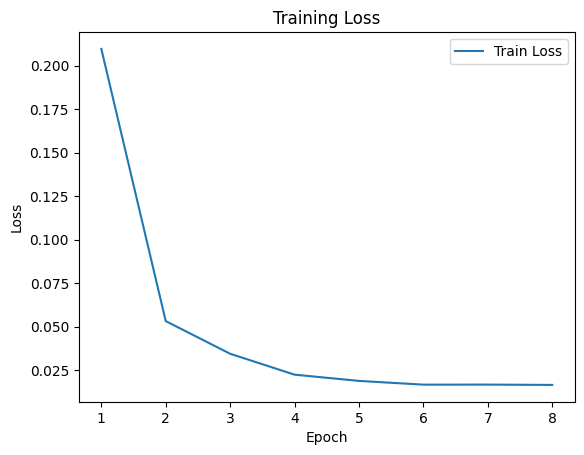

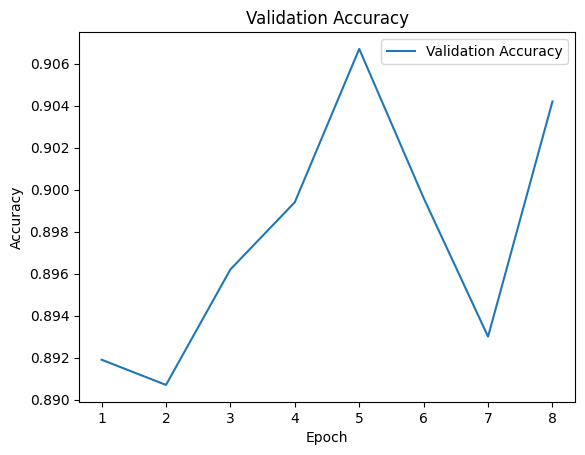

In [ ]:
import matplotlib.pyplot as plt
ep = range(1, len(train_loss_history) + 1)

# Plotting train loss curve
plt.figure()
plt.plot(ep, train_loss_history, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plotting validation accuracy curve
plt.figure()
plt.plot(ep, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()